## Loading all required packages, and checking to see if I have GPU avaliable

In [2]:
import torch
import torch.utils.data
from  torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline 
import librosa
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Problem 1 Image Classification

#### Overall this probem was an interesting one, we were able to create a 5 layer neural network that was able to classify the images with 98% accuracy after a short number of epochs. We also saw how we can use PCA and TSNE to lower dimmension and plot on the 2 dimensional space. This allowed use to see how different layers did in their classification of the proper class.

## Loading Data

In [3]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('/dataset/',
                                         train=True,
                                         download=True,
                                        transform=transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                        ])),batch_size=128, shuffle=True)


#Set shuffle to false to batch predit and store predictions for later comparison
test_loader = torch.utils.data.DataLoader(datasets.MNIST('/dataset/',
                                       train=False,
                                       download=True,
                                       transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                       ])),batch_size=10000, shuffle=False)

## Creating NN Network With PyTorch

* Network contains 5 layers
  * Layers 1 -   Loading 748 neuron and expanding 1024 neurons.
  * Layers 2-4 - All with 1024 neurons
  * Layer 5 -    Getting predictions for the 10 classes. 

In [4]:
class Net(nn.Module):
  def __init__ (self):
    super(Net, self).__init__()
    self.l1 = nn.Linear(28*28, 1024)
    self.l2 = nn.Linear(1024,1024)
    self.l3 = nn.Linear(1024,1024)
    self.l4 = nn.Linear(1024,1024)
    self.l5 = nn.Linear(1024,10)
    
  def forward(self,x):
    out1 = F.relu(self.l1(x))
    out2 = F.relu(self.l2(out1))
    out3 = F.relu(self.l3(out2))
    out4 = F.relu(self.l4(out3))
    out5 =  F.log_softmax(self.l5(out4))
    return out1, out2, out3, out4, out5
  

In [5]:
net = Net()
print(net)

Net(
  (l1): Linear(in_features=784, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=1024, bias=True)
  (l3): Linear(in_features=1024, out_features=1024, bias=True)
  (l4): Linear(in_features=1024, out_features=1024, bias=True)
  (l5): Linear(in_features=1024, out_features=10, bias=True)
)


## Selecting Optimizer and Loss Function

* Optimizer is set to stochastic gradient decent
* Loss Set to NNLOSS

In [6]:
opt = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)
crit = nn.NLLLoss()

## Training model via batch, over 10 epochs, priting results every 200 itterations in batch

In [7]:
epochs = 10
printAt = 200
correct = 0
fourth = []
# run the main training loop
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data)
        target = Variable(target)
        
        data = data.view(-1, 28*28)
        opt.zero_grad()
        out1, out2, out3, out4,net_out = net(data)
        
        loss = crit(net_out, target)
        loss.backward()
        opt.step()
        
        output = net_out.data.max(1)[1]
        correct += (output == target).float().sum()
        fourth.append(out4)
        if batch_idx % printAt == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100.* batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.data:.6f}')
    print((f'Overall accuracy = {correct/len(train_loader.dataset)*100}'))
    correct = 0

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301463


/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.463424
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.204193
Overall accuracy = 82.91000366210938
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.130450
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.209673
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.195730
Overall accuracy = 95.8949966430664
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.092905
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.096813
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.082246
Overall accuracy = 97.49500274658203
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.066948
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.036179
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.100832
Overall accuracy = 98.30999755859375
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.012087
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.011696
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.044447
Overall accuracy = 98.80333709716797
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.021299
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.005732
Train Epoch: 5 [51200/60000 (85%)]	Loss: 

## Measuring model against test data

In [8]:
test_loss = 0
correct = 0
predictions = []
fourth = []
for data, target in test_loader:
    data = Variable(data, volatile=True)
    target = Variable(target)
    data = data.view(-1, 28 * 28)
    
    out1, out2, out3, out4,net_out = net(data)
    test_loss += crit(net_out, target).data
    blank, pred = torch.max(net_out.data,1)  
    
    correct += pred.eq(target.data).sum()
    predictions += list(pred.numpy())
    fourth.append(out4)


test_loss /= len(test_loader.dataset)
print((f'\nTest set: Average loss: {test_loss:.4f}, '
      f'Accuracy: {correct}/{len(test_loader.dataset)}'
      f'({100. * correct / len(test_loader.dataset):.0f}%)'))
        

/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  



Test set: Average loss: 0.0000, Accuracy: 9811/10000(98%)


/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


## Plotting 10 images of classified classes from the train dataset 

In [9]:
indTar = []
for x in range(10):
    indTar.append(list(np.where(np.array(predictions) == x)[0][:10]))
indTar

[[3, 10, 13, 25, 28, 55, 69, 71, 101, 126],
 [2, 5, 14, 29, 31, 37, 39, 40, 46, 57],
 [1, 35, 38, 43, 47, 72, 77, 82, 106, 119],
 [18, 30, 32, 44, 51, 63, 68, 76, 87, 90],
 [4, 6, 19, 24, 27, 33, 42, 48, 49, 56],
 [8, 15, 23, 45, 52, 53, 59, 102, 104, 120],
 [11, 21, 22, 50, 54, 66, 81, 88, 91, 98],
 [0, 17, 26, 34, 36, 41, 60, 64, 70, 75],
 [61, 84, 110, 128, 134, 146, 177, 179, 181, 184],
 [7, 9, 12, 16, 20, 58, 62, 73, 78, 92]]

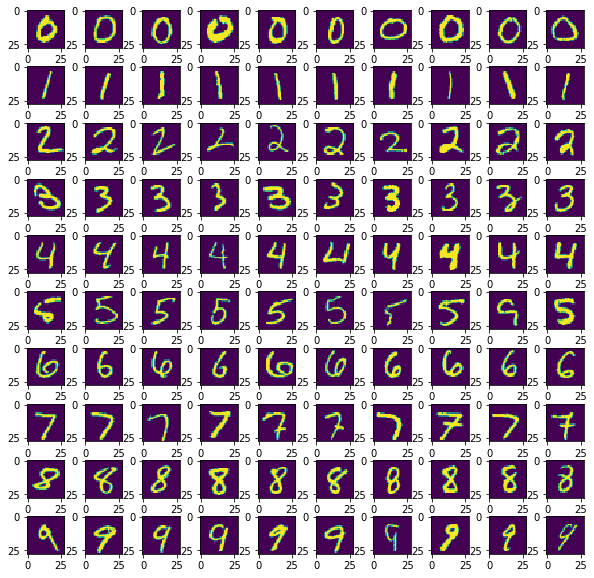

In [10]:
fig, axes = plt.subplots(10,10,figsize  = (10,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(10):
  for j in range(10):
    loc  = indTar[i][j]
    axes[i,j].imshow(test_loader.dataset.data[loc].numpy())


## Getting 10 random features from the fourth layer output and plotting the classified classes

In [11]:
fin = np.argmax(fourth[0].detach().numpy()[:,np.random.randint(1024,size=10)],axis=1)
indTar = []
for x in range(10):
  indTar.append(list(np.where(fin == x)[0][:10]))
indTar

[[1, 2, 5, 11, 14, 18, 29, 34, 35, 36],
 [17, 26, 33, 60, 70, 121, 124, 301, 415, 425],
 [],
 [0, 4, 6, 7, 8, 9, 12, 15, 16, 19],
 [3, 10, 13, 21, 22, 25, 28, 50, 55, 69],
 [30, 32, 68, 90, 112, 173, 200, 205, 213, 216],
 [],
 [],
 [300, 399, 610, 770, 1348, 1800, 2145, 2516, 2778, 2963],
 [8182]]

#### Here we notice a few rows have empty rows because some dimensions do not have all 10 features. We can also see that randomly selecting features from the fourth layer does very poorly compared to the final layer. We do see one of the rows beeing all 3, this might indicate that the features here might be relevant just for the class 3. 

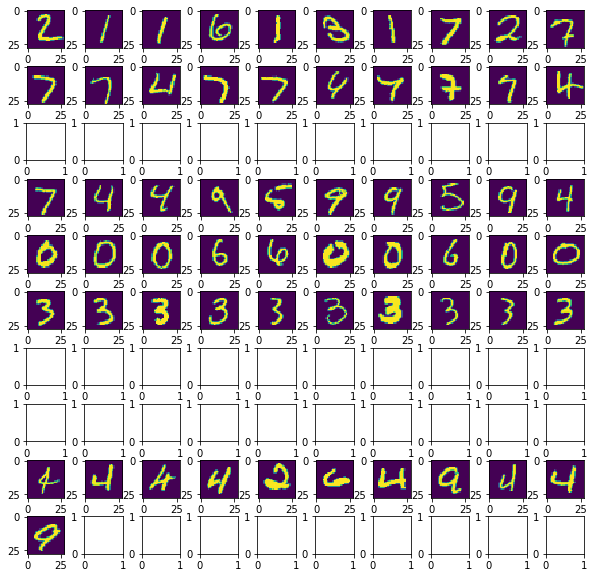

In [12]:
fig, axes = plt.subplots(10,10,figsize  = (10,10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(10):
  for j in range(10):
    if j < len(indTar[i]):
      loc  = indTar[i][j]
      axes[i,j].imshow(test_loader.dataset.data[loc].numpy())

## Applying PCA & TSNE to each layer output

#### As we transitioned through each layer we notice both the PCA model and the TSNE models get better. Overall the TSNE model does a much better job in splitting the classes over the PCA model 

In [13]:
def PlotMap(transformed, tstLabel):
    plt.rcParams['font.size'] = 18
    plt.rcParams['font.weight'] = 'bold'
    fig, axes = plt.subplots(nrows= 1, ncols= 1,figsize  = (8,8))
    axes.scatter(x = transformed[:,0], y = transformed[:,1], c = tstLabel)
    for j in range(0,11):
        x = transformed[np.where(tstLabel ==j)][:,0].mean()
        y = transformed[np.where(tstLabel ==j)][:,1].mean()
        axes.annotate(str(j),xy = (x,y))
    
    

In [14]:
tstImg = np.random.randint(10000,size = 1000)
tstImg.sort()
tstData = data[tstImg]
tstLabel = target[tstImg]

/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/Users/kajol579/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/Users/kajol579/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


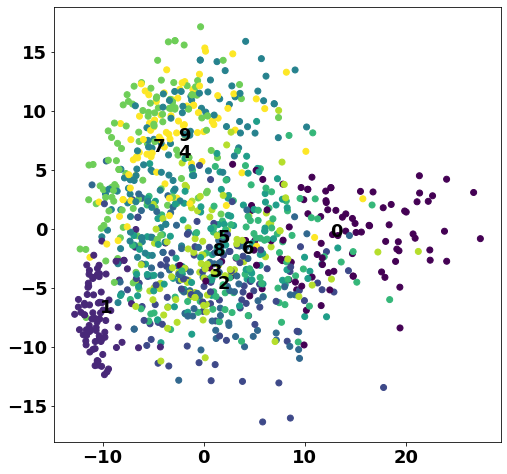

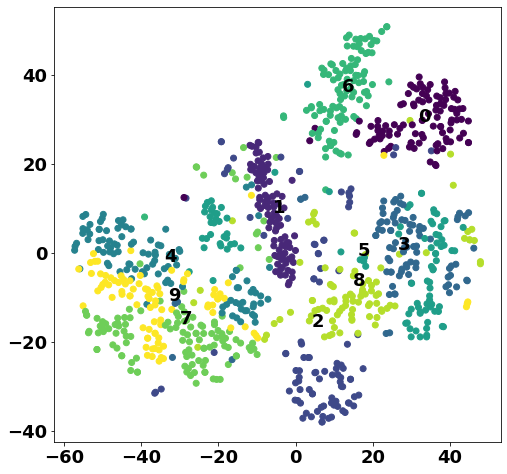

In [15]:
transformed = PCA(n_components = 2).fit_transform(tstData)
transformedTSNE = TSNE(n_components = 2).fit_transform(tstData)
PlotMap(transformed, tstLabel)
PlotMap(transformedTSNE, tstLabel)

In [16]:
layerData1 = out1[tstImg].detach().numpy()
layerData2= out2[tstImg].detach().numpy()
layerData3= out3[tstImg].detach().numpy()
layerData4= out4[tstImg].detach().numpy()
layerData5= net_out[tstImg].detach().numpy()

### Layer 1 PCA & TSNE

/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/Users/kajol579/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


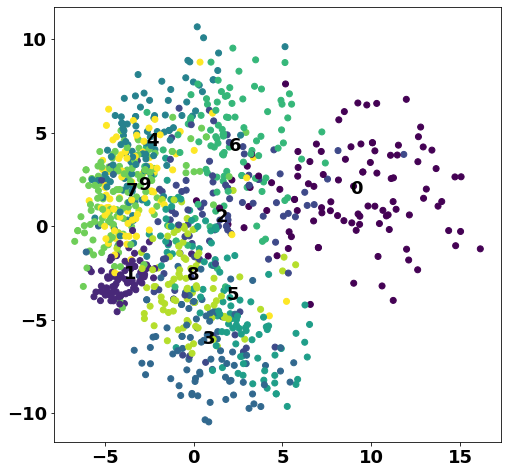

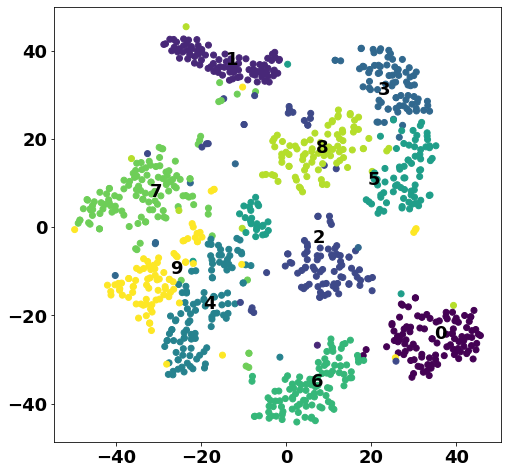

In [17]:
layerTranPCA1 = PCA(n_components = 2).fit_transform(layerData1) 
layerTranTSNE1 = TSNE(n_components = 2).fit_transform(layerData1)
PlotMap(layerTranPCA1, tstLabel)
PlotMap(layerTranTSNE1,tstLabel)

### Layer 2 PCA & TSNE

/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/Users/kajol579/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


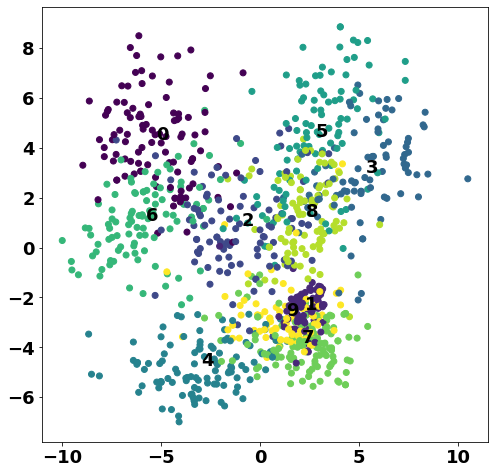

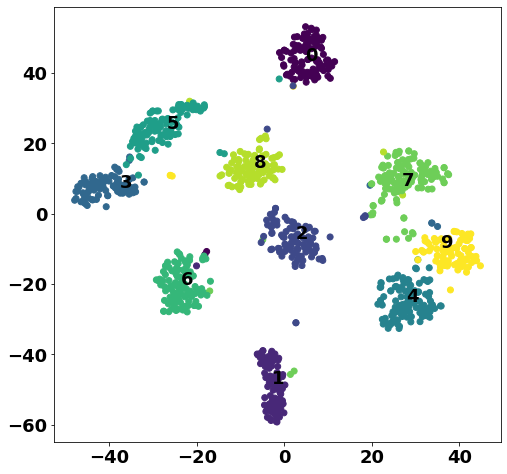

In [18]:
layerTranPCA2 = PCA(n_components = 2).fit_transform(layerData2) 
layerTranTSNE2 = TSNE(n_components = 2).fit_transform(layerData2)
PlotMap(layerTranPCA2, tstLabel)
PlotMap(layerTranTSNE2,tstLabel)

### Layer 3 PCA & TSNE

/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/Users/kajol579/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


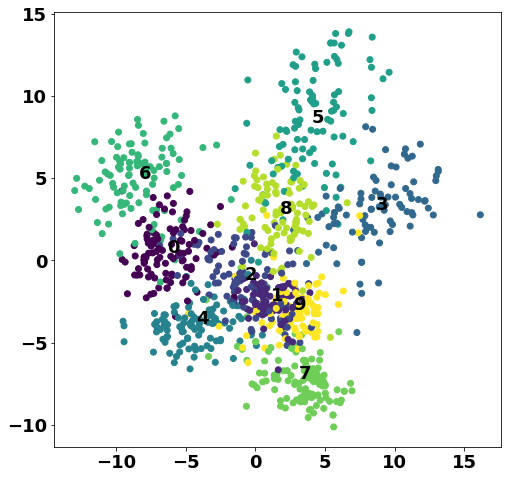

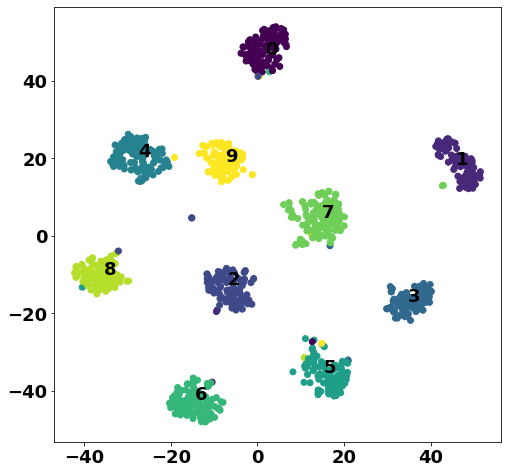

In [19]:
layerTranPCA3 = PCA(n_components = 2).fit_transform(layerData3) 
layerTranTSNE3 = TSNE(n_components = 2).fit_transform(layerData3)
PlotMap(layerTranPCA3, tstLabel)
PlotMap(layerTranTSNE3,tstLabel)

### Layer 4 PCA & TSNE

/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/Users/kajol579/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


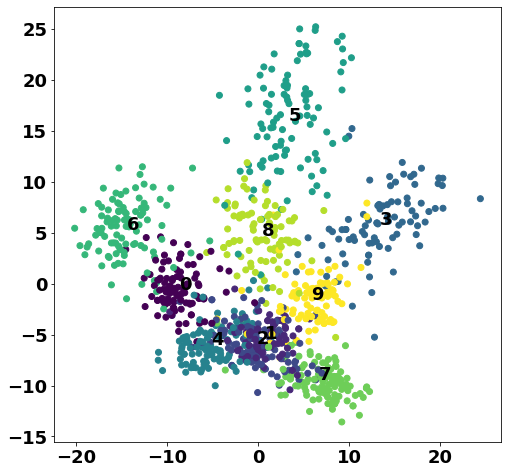

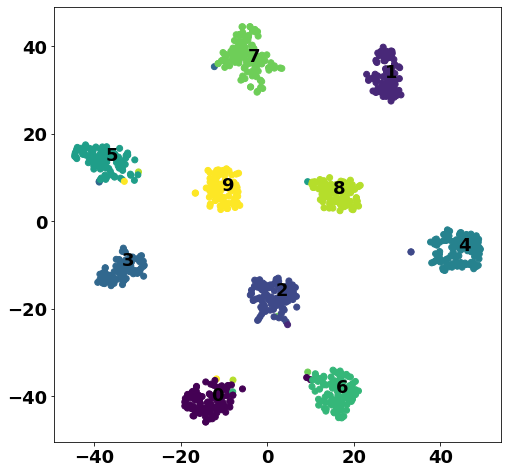

In [20]:
layerTranPCA4 = PCA(n_components = 2).fit_transform(layerData4) 
layerTranTSNE4 = TSNE(n_components = 2).fit_transform(layerData4)
PlotMap(layerTranPCA4, tstLabel)
PlotMap(layerTranTSNE4,tstLabel)

### Layer 5 PCA & TSNE

/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/Users/kajol579/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


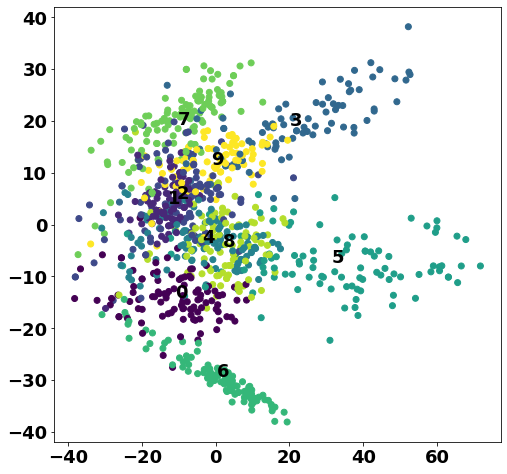

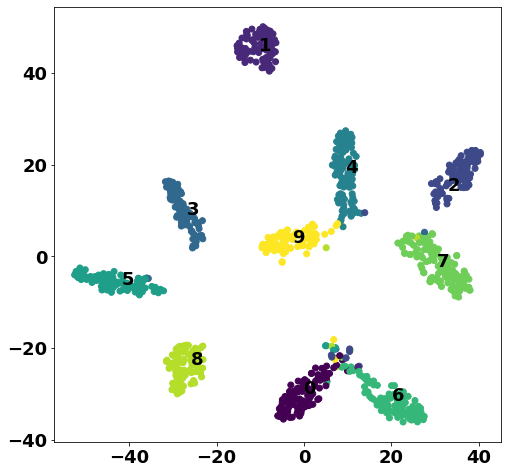

In [21]:
layerTranPCA5 = PCA(n_components = 2).fit_transform(layerData5) 
layerTranTSNE5 = TSNE(n_components = 2).fit_transform(layerData5)
PlotMap(layerTranPCA5, tstLabel)
PlotMap(layerTranTSNE5,tstLabel)

# Problem 2 Sound De-Noising

#### This problem was a new challange for me as I have never worked with sound data. We were able to clean up the test data pretty well from the chip eating noise. The other 2 datasets test_x_01.wav and test_x_02.wav did fairly good as well. 

## Loading audio train data

In [22]:
s, sr=librosa.load(r'/Users/kajol579/Desktop/Naimesh/Deep Learning/data/train_clean_male.wav', sr=None)
S=librosa.stft(s, n_fft=1024, hop_length=512)
                   
sn, sr=librosa.load(r'/Users/kajol579/Desktop/Naimesh/Deep Learning/data/train_dirty_male.wav', sr=None)
X=librosa.stft(sn, n_fft=1024, hop_length=512)


In [23]:
SNR = 10 * np.log10(np.sum(np.square(s)) / np.sum(np.square(sn)))
print(SNR)

-0.8756765723228455


## Taking the magnitude and transforming the data for training

In [24]:
absS = np.abs(S).T
absX = np.abs(X).T

## Building a four layer neural network

In [26]:
class ANet(nn.Module):
  def __init__ (self):
    super(ANet, self).__init__()
    self.l1 = nn.Linear(513, 700)
    self.l2 = nn.Linear(700,1000)
    self.l3 = nn.Linear(1000,600)
    self.l4 = nn.Linear(600,513)
    
  def forward(self,x):
    out1 = F.relu(self.l1(x))
    out2 = F.relu(self.l2(out1))
    out3 = F.relu(self.l3(out2))
    out4 = F.relu(self.l4(out3))
    return out1, out2,out3, out4
  

## Setting the optimizor to Adam and the Loss to MSNE
## Training over 200 epochs and printing every 20 itterations

In [27]:
net2 = ANet()
optA = optim.Adam(net2.parameters(), lr = 0.001)
critA = nn.MSELoss()
epochs = 200
printA = 20

In [28]:
for epoch in range(epochs):
    data = Variable(torch.tensor(absX))
    target = Variable(torch.tensor(absS))

    optA.zero_grad()
    out1, out2,out3, net_out = net2(data)

    loss = critA(net_out, target)
    loss.backward()
    optA.step()
    if (epoch%printA) == 0:
        print(f'The Loss = {loss} on Epoch {epoch}')

The Loss = 0.09757061302661896 on Epoch 0
The Loss = 0.029095465317368507 on Epoch 20
The Loss = 0.014969524927437305 on Epoch 40
The Loss = 0.010349302552640438 on Epoch 60
The Loss = 0.007905883714556694 on Epoch 80
The Loss = 0.006508893333375454 on Epoch 100
The Loss = 0.005605853162705898 on Epoch 120
The Loss = 0.004959391430020332 on Epoch 140
The Loss = 0.004500788636505604 on Epoch 160
The Loss = 0.004354395437985659 on Epoch 180


## Loading test data

In [29]:
st, sr=librosa.load(r'/Users/kajol579/Desktop/Naimesh/Deep Learning/data/test_x_01.wav', sr=None)
Xt=librosa.stft(st, n_fft=1024, hop_length=512)
absXt =np.abs(Xt).T

## Applying model to test data and getting cleaned results

In [30]:
data = Variable(torch.tensor(absXt), volatile=True)
out1, out2,out3, net_out = net2(data)

/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


## Exporting cleaned test data

In [31]:
tst = (Xt/np.abs(Xt))
tst2= np.multiply(tst, net_out.detach().numpy().T)
sh_test = librosa.istft(tst2,hop_length=512)
librosa.output.write_wav(r'/Users/kajol579/Desktop/Naimesh/Deep Learning/data/test_s_01_recons.wav', sh_test, sr)

## Loading professor dirty noise data

In [32]:
st2, sr=librosa.load(r'/Users/kajol579/Desktop/Naimesh/Deep Learning/data/test_x_02.wav', sr=None)
Xt2=librosa.stft(st2, n_fft=1024, hop_length=512)
absXt2 =np.abs(Xt2).T

## Applying model to test data and getting cleaned results

In [33]:
data = Variable(torch.tensor(absXt2), volatile=True)
out1, out2,out3, net_out = net2(data)

/Users/kajol579/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """Entry point for launching an IPython kernel.


## Exporting cleaned data

In [34]:
tst = (Xt2/np.abs(Xt2))
tst2= np.multiply(tst, net_out.detach().numpy().T)
sh_test = librosa.istft(tst2,hop_length=512)
librosa.output.write_wav(r'/Users/kajol579/Desktop/Naimesh/Deep Learning/data/test_s_02_recons.wav', sh_test, sr)